### Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
sys.path.append(os.path.abspath(".."))

### Google Colab
# !git clone https://github.com/Belashov641618/OpticalEncoder.git
# sys.path.append(os.path.abspath("OpticalEncoder"))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
%pip install belashovplot
%pip install optuna
%pip install timm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Создание функции минимизации для optuna

In [5]:
# Не изменяемые параметры системы
# Когерентность
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6

# Оптика
wavelength = 500.0E-9


# Детекторы

# Электроника

In [6]:
def objective(trial:optuna.trial):
  mean_samples      = trial.suggest_int('mean_samples', 1, 30)
  mask_unit_length  = trial.suggest_categorical('mask_unit_length', [7.0E-6, 14.0E-6, 21.0E-6, 28.0E-6, 35.0E-6, 42.0E-6, 49.0E-6])
  mask_units        = trial.suggest_int('mask_units', 10, 250)

  length = mask_unit_length * mask_units


## Настройка некогерентности

In [7]:
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 10 #100

print(f"Временная когерентность:        {engineering(time_coherence, 'с')}")
print(f"Время релаксации:               {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность: {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:          {mean_samples}")

Временная когерентность:        10.0 нс
Время релаксации:               1.0 мкc
Пространственная когерентность: 50.0 мкм
Количество усреднений:          10


## Система без линз

### Настройка параметров системы

In [8]:
length = 5.0E-3
wavelength = 500E-9
mask_unit_length = 30.0E-6
masks_amount = 5
cppp = 2

pixels = int(length/mask_unit_length) + 1
N = int(pixels*cppp)
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.05

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Количество модуляторов:                   {masks_amount}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(mask_unit_length, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       334
Количество пикселей маски:                167
Количество модуляторов:                   5
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     30.0 мкм
Расстояние между слоями:                  14.998 мм


### Отрисовка некогерентности

0.0006299755768850446 0.48211465664062503
0.0006046973867341876 0.2975162139490659
0.0036718242336064577 0.36719853397266594
0.00689712492749095 0.45320139552044214
0.0023332200944423676 0.5593472900873986
0.0019683591090142727 0.3451769941802883
2.0453015167731792e-05 0.21301105667772507
3.6109024222241715e-05 0.26290112627414564
3.141707929898985e-05 0.32447612473367893
0.0009966399520635605 0.4004728203879891
0.000252541241934523 0.2471344848579303
0.0004431798297446221 0.15250836135851367
0.00047489377902820706 0.09411394082711576
0.0001789600501069799 0.11615669828342019
3.37113015120849e-05 0.017920270947014337
7.58175810915418e-05 0.02211744070278857
5.828005669172853e-05 0.027297644365297396
2.5245775759685785e-05 0.03369112176709951
5.947667523287237e-05 0.041582038022611637
2.0311674234108068e-05 0.025660556779121692
4.278511187294498e-05 0.007917651533295052
3.630840728874318e-05 0.009772072576959135
9.485138434683904e-05 0.012060824102676277
0.0001440043852198869 0.01488563

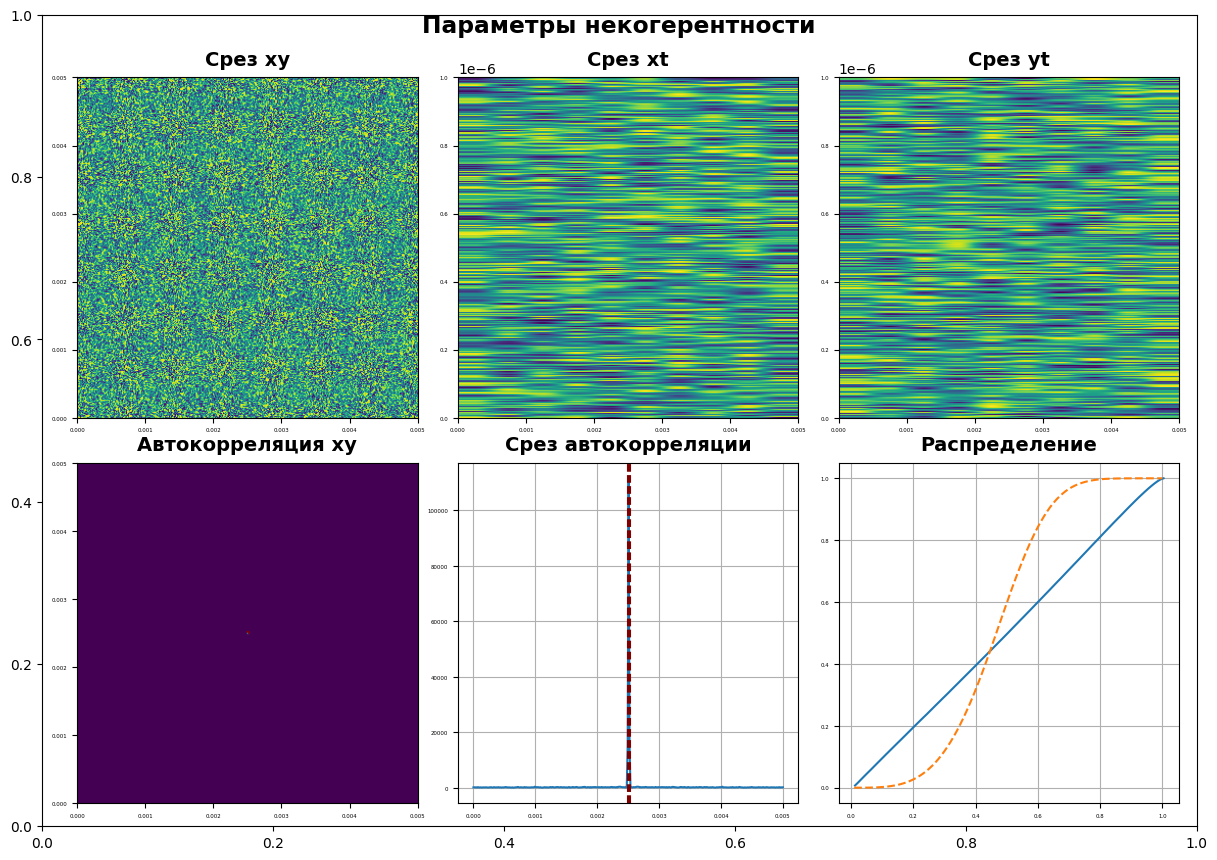

In [9]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent = incoherent.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
incoherent.delayed.launch()
incoherent.show()

### Инициализация оптической модели

In [10]:
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.3)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [phase_modulators[0], amplitude_modulators[0]]
for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
    elements.append(propagation)
    elements.append(phase_modulator)
    elements.append(amplitude_modulator)
elements.append(propagation)

chunker = CudaMemoryChunker(6)

optical = CompositeModel(*elements)
optical.wrap(chunker)
optical.wrap(incoherent)
optical.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

CompositeModel(
  (Element0): PhaseModulator()
  (Element1): AmplitudeModulator()
  (Element2): FurrierPropagation()
  (Element3): PhaseModulator()
  (Element4): AmplitudeModulator()
  (Element5): FurrierPropagation()
  (Element6): PhaseModulator()
  (Element7): AmplitudeModulator()
  (Element8): FurrierPropagation()
  (Element9): PhaseModulator()
  (Element10): AmplitudeModulator()
  (Element11): FurrierPropagation()
  (Element12): PhaseModulator()
  (Element13): AmplitudeModulator()
  (Element14): FurrierPropagation()
  (Wrapper0): CudaMemoryChunker()
  (Wrapper1): Incoherent(
    (_generator): GaussianNormalizer(
      (_generator): FourierMask()
    )
  )
)

### Инициализация детекторов

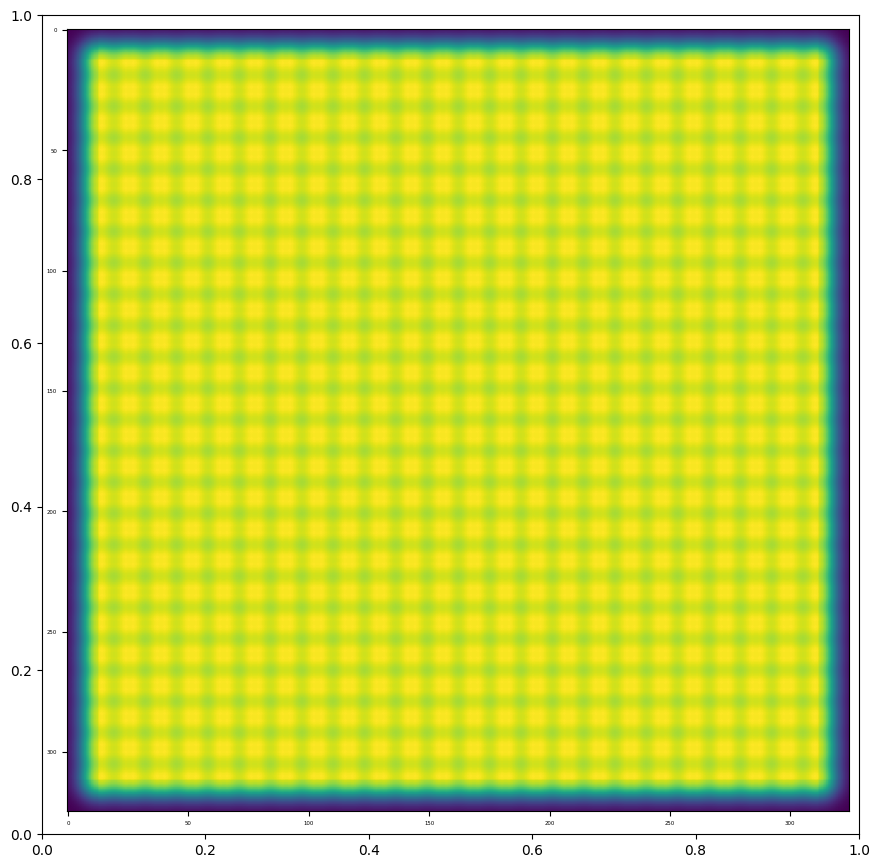

In [11]:
detectors_amount = 24

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((length/60, length/60), (0,0))
# detectors_filter = Window(centers=(0.,0.), sizes=(length/34, length/34))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter)
detectors.to(optical.device)

plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.axes.add(0,0).imshow(detectors.filter, aspect='auto')
plot.show()

### Инициализация электронной модели

In [12]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10)
electronic.to(optical.device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

### Инициализация гибридной модели

In [13]:
model = HybridModel(optical, detectors, electronic)

In [14]:
dataset = Dataset('CIFAR10', 30, N, N, torch.complex64)
dataset.train
dataset.test

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# dsi = iter(dataset.train)
# with torch.no_grad():
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))
    # model.visualize(next(dsi)[0][:1, :1].to(model.device))


### Инициализация лосс функции и обучающего модуля

In [16]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Обучение модели

In [17]:
history = []
confusions = []

In [18]:
confusions.append(confusion(model, dataset))
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  history.append(train(model, dataset, optimizer, loss_function))
  confusions.append(confusion(model, dataset))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:32<00:00,  2.18it/s]


Accuracy: 10.0


RLoss: 1.9644291434306593, RPI1000: -0.23005407168761907: 100%|████████████████████████████████████████████| 1667/1667 [23:54<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.24it/s]


Accuracy: 29.98


RLoss: 1.8751096136177017, RPI1000: -0.0738355928606165: 100%|█████████████████████████████████████████████| 1667/1667 [23:32<00:00,  1.18it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 35.11


RLoss: 1.7087664997758536, RPI1000: -0.03776827603235503: 100%|████████████████████████████████████████████| 1667/1667 [23:19<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:24<00:00,  2.31it/s]


Accuracy: 37.41


RLoss: 1.875974719671047, RPI1000: -0.02530266390624935: 100%|█████████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 39.3


RLoss: 1.6131283450604617, RPI1000: -0.012521940826752327: 100%|███████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 40.31


RLoss: 1.7621485148730422, RPI1000: -0.02005535130754615: 100%|████████████████████████████████████████████| 1667/1667 [23:20<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 41.64


RLoss: 1.6934766296417771, RPI1000: 0.008124699757640989: 100%|████████████████████████████████████████████| 1667/1667 [23:20<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 42.68


RLoss: 1.5625500547781854, RPI1000: 0.013938098140921134: 100%|████████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 43.31


RLoss: 1.5897832744864355, RPI1000: 0.013967119306968643: 100%|████████████████████████████████████████████| 1667/1667 [23:23<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 43.48


RLoss: 1.5748762130435605, RPI1000: 0.013994658204555994: 100%|████████████████████████████████████████████| 1667/1667 [23:22<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:24<00:00,  2.30it/s]

Accuracy: 43.71


In [19]:
print(confusions[0], '\n', confusions[-1])

[[   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]] 
 [[412.  65.  99.  27.  74.  20.  56.  56. 145.  46.]
 [ 29. 549.   5.  31.  25.  18.  53.  32.  79. 179.]
 [ 77.  33. 289. 105. 136. 109. 124.  63.  37.  27.]
 [ 41.  51.  48. 267.  74. 158. 149.  83.  36.  93.]
 [ 64.  40. 114.  57. 310.  62. 152. 128.  38.  35.]
 [ 26.  25.  64. 181.  62. 377.  76. 116.  24.  49.]
 [ 25.  67.  48.  66. 101.  37. 544.  34.  20.  5

In [20]:
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.1
for module in model.optical._propagators:
    module.distance = distance

print(model.optical._propagators[0].distance)

0.02999583304394129


In [21]:
confusions.append(confusion(model, dataset))
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  history.append(train(model, dataset, optimizer, loss_function))
  confusions.append(confusion(model, dataset))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:26<00:00,  2.28it/s]


Accuracy: 16.99


RLoss: 1.929795066342124, RPI1000: -0.1050408324423534: 100%|██████████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 31.61


RLoss: 1.8926707828090472, RPI1000: -0.015575667100417311: 100%|███████████████████████████████████████████| 1667/1667 [23:23<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 33.28


RLoss: 1.8677943459638118, RPI1000: -0.012975923216839668: 100%|███████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.29it/s]


Accuracy: 34.3


RLoss: 1.8734623408372468, RPI1000: -0.008082546097035834: 100%|███████████████████████████████████████████| 1667/1667 [23:27<00:00,  1.18it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.25it/s]


Accuracy: 35.52


RLoss: 1.7721060424843444, RPI1000: -0.0022104724200809824: 100%|██████████████████████████████████████████| 1667/1667 [23:55<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 35.58


RLoss: 1.6693634822191226, RPI1000: -0.0093597131464662: 100%|█████████████████████████████████████████████| 1667/1667 [23:22<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 35.51


RLoss: 1.6884451648553225, RPI1000: 0.010479196977409483: 100%|████████████████████████████████████████████| 1667/1667 [23:32<00:00,  1.18it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.25it/s]


Accuracy: 36.24


RLoss: 1.7189612596269284, RPI1000: 0.0034400887029488294: 100%|███████████████████████████████████████████| 1667/1667 [23:53<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 36.84


RLoss: 1.720475163687127, RPI1000: 0.004579801395685361: 100%|█████████████████████████████████████████████| 1667/1667 [23:21<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 36.56


RLoss: 1.8862920033590866, RPI1000: 0.006314377628771714: 100%|████████████████████████████████████████████| 1667/1667 [23:22<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]

Accuracy: 37.8


In [22]:
print(confusions[0], '\n', confusions[-1])

[[   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]] 
 [[358.  61. 119.  26.  66.  26.  79.  52. 139.  74.]
 [ 42. 423.  16.  33.  34.  27.  78.  47.  97. 203.]
 [ 62.  33. 290.  95. 105.  78. 161.  77.  47.  52.]
 [ 55.  43.  63. 247.  64. 152. 145.  88.  53.  90.]
 [ 60.  56. 135.  56. 256.  47. 180. 115.  60.  35.]
 [ 40.  34.  88. 162.  54. 312. 113.  95.  49.  53.]
 [ 42.  49.  83.  76.  80.  47. 484.  52.  34.  5

In [23]:
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.3
for module in model.optical._propagators:
    module.distance = distance

print(model.optical._propagators[0].distance)

0.08998749913182387


In [24]:
confusions.append(confusion(model, dataset))
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  history.append(train(model, dataset, optimizer, loss_function))
  confusions.append(confusion(model, dataset))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 9.55


RLoss: 2.188433519556462, RPI1000: -0.06312428830023316: 100%|█████████████████████████████████████████████| 1667/1667 [23:35<00:00,  1.18it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 21.38


RLoss: 2.1441238707009456, RPI1000: -0.030774433116602187: 100%|███████████████████████████████████████████| 1667/1667 [23:55<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 22.87


RLoss: 2.1605458250153715, RPI1000: -0.015371236316762741: 100%|███████████████████████████████████████████| 1667/1667 [23:26<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 23.36


RLoss: 2.0816492472542514, RPI1000: -0.011498327581751235: 100%|███████████████████████████████████████████| 1667/1667 [23:22<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 23.78


RLoss: 2.0475557494160768, RPI1000: -0.008947763671869752: 100%|███████████████████████████████████████████| 1667/1667 [23:22<00:00,  1.19it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]


Accuracy: 21.6


RLoss: 2.0050577728919023, RPI1000: -0.005721081564310608: 100%|███████████████████████████████████████████| 1667/1667 [23:29<00:00,  1.18it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.25it/s]


Accuracy: 25.76


RLoss: 1.9785394861981525, RPI1000: -0.008946632373254094: 100%|███████████████████████████████████████████| 1667/1667 [23:57<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 25.68


RLoss: 1.9891165334318583, RPI1000: -0.005714220682037011: 100%|███████████████████████████████████████████| 1667/1667 [23:59<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 26.63


RLoss: 2.033642924019609, RPI1000: -0.0002541737783555061: 100%|███████████████████████████████████████████| 1667/1667 [24:00<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.24it/s]


Accuracy: 26.47


RLoss: 2.0381418023793643, RPI1000: -0.0007981014572444706: 100%|██████████████████████████████████████████| 1667/1667 [23:40<00:00,  1.17it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:25<00:00,  2.30it/s]

Accuracy: 26.17


In [25]:
print(confusions[0], '\n', confusions[-1])

[[   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.]] 
 [[218.  71.  85.  29.  53.  63.  66.  69. 230. 116.]
 [ 28. 204.  35.  53.  58.  52.  88.  48. 221. 213.]
 [ 97.  49. 177.  77.  92. 116. 134.  64. 130.  64.]
 [ 64.  55.  68. 136.  76. 219. 111.  75. 102.  94.]
 [ 46.  64. 120.  64. 176.  91. 170.  87. 124.  58.]
 [ 48.  29.  62. 107.  60. 349.  75.  75. 107.  88.]
 [ 45.  77. 103.  63.  71. 113. 301.  65.  99.  6

In [26]:
distance = length * sqrt((mask_unit_length/wavelength)**2-1) * 0.5
for module in model.optical._propagators:
    module.distance = distance

print(model.optical._propagators[0].distance)

0.14997916521970645


In [ ]:
confusions.append(confusion(model, dataset))
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  history.append(train(model, dataset, optimizer, loss_function))
  confusions.append(confusion(model, dataset))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.24it/s]


Accuracy: 9.92


RLoss: 2.194618443048018, RPI1000: -0.06525380338984722: 100%|█████████████████████████████████████████████| 1667/1667 [24:19<00:00,  1.14it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:29<00:00,  2.23it/s]


Accuracy: 18.69


RLoss: 2.167319707999443, RPI1000: -0.017164685534118915: 100%|████████████████████████████████████████████| 1667/1667 [24:14<00:00,  1.15it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.25it/s]


Accuracy: 19.36


RLoss: 2.1744028829275877, RPI1000: -0.008046597994749575: 100%|███████████████████████████████████████████| 1667/1667 [23:59<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:28<00:00,  2.25it/s]


Accuracy: 18.94


RLoss: 2.077723843112153, RPI1000: -0.004326532057719549: 100%|████████████████████████████████████████████| 1667/1667 [24:01<00:00,  1.16it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [02:36<00:00,  2.13it/s]


Accuracy: 17.49


RLoss: 2.0909524238971957, RPI1000: 0.45050314629169436:   2%|▊                                              | 28/1667 [00:25<24:57,  1.09it/s]

In [ ]:
print(confusions[0], '\n', confusions[-1])

## Оптимизация ResNet14

In [ ]:
resnet = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10)
resnet = resnet.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

dataset = Dataset('CIFAR10', 50, 32, 32)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

confusions = [confusion(resnet, dataset, 10)]
print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')
for i in range(10):
  train(resnet, dataset, optimizer, loss_function)
  confusions.append(confusion(resnet, dataset, 10))
  print(f'Accuracy: {100 * numpy.sum(numpy.diagonal(confusions[-1], 0)) / numpy.sum(confusions[-1])}')